# Topic Coherence

In this notebook, topic coherence is calculated for the LDA models trained on the corresponding input that every use case indicates. For each use case, multiple LDA models are trained with number of topics from 2 to 100 or 123, in order to find the optimal number of topics for each use case's LDA model (the one with the largest topic coherence score).

In [1]:
import re, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import codecs
from pprint import pprint
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.models import CoherenceModel

warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

### Load Data for the use cases 

In [2]:
# Use cases 1 & 3
with open("C:/Users/anast/Desktop/Thesis/MachineLearning/Ontology/DatasetOntology/all.txt") as f:
    data = f.read().splitlines()

# Use cases 2 & 4
# with open("C:/Users/anast/Desktop/Thesis/MachineLearning/Data/datasetProjects.txt") as f:
#     data = f.read().splitlines()

# # Use Cases 5 & 7
# with open("C:/Users/anast/Desktop/Thesis/MachineLearning/Ontology/DatasetOntology/Th-Ur-all.txt") as f:
#     data = f.read().splitlines()

# # Use Cases 6 & 8
# with open("C:/Users/anast/Desktop/Thesis/MachineLearning/Data/Th-Ur-Projects.txt") as f:
#     data = f.read().splitlines()

### Preprocessing of data
- Exclude the words of common functioanallity according to the use cases 3,4,7,8
- Clean from numbers, punctuation and stop words
- Lemmatize the words

In [3]:
exclude = []
rules = pd.read_csv('C:/Users/anast/Desktop/Results/results-all1.csv')
rules = rules[(rules['Support']>0.2)][['Left Hand Side', 'Right Hand Side']]
exclude.extend(rules['Left Hand Side'].tolist())
exclude.extend(rules['Right Hand Side'].tolist())
exclude = list(dict.fromkeys(exclude))
exclude.extend(['datum', 'administrator', 'log', 'know', 'able', 'ability'])
# exclude = []
# exclude.extend(['able', 'ability'])
# exclude = []

nlp = spacy.load("en_core_web_lg")
# Clean the data from numbers, punctuation and stop words
clean_corpus = []
for line in data:
    doc = nlp(line)
    cleanData = []
    for token in doc:
        if not token.is_alpha:
            continue
        elif token.is_stop:
            continue
        elif token.pos_ == "PUNCT":
            continue
        elif token.text in exclude:
            continue
        elif token.lemma_ in exclude:
            continue 
        else:
            cleanData.append(token.lemma_)
    clean_corpus.append(cleanData)

### Build the bigram and trigram models

In [4]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(clean_corpus, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[clean_corpus], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

texts = [bigram_mod[doc] for doc in clean_corpus]
texts = [trigram_mod[bigram_mod[doc]] for doc in texts]

data_ready = texts

### Create the dictionary and the corpus

In [5]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [6]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [7]:
start = 2
limit = 123 # 123 for the use cases 1-4, 100 for the use cases 5-8
step = 1
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=start, limit=limit, step=step)

### Topic coherence plot

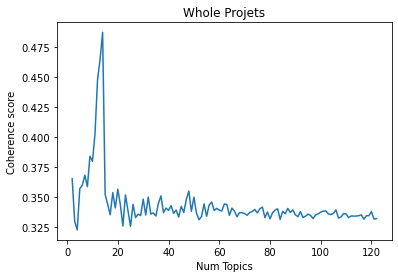

In [8]:
# Show graph
limit=limit; start=start; step=step;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
plt.title('Whole Projets')
plt.savefig('../../coherence.jpg')
plt.show()

### Sort number of topics based on topic coherence

In [9]:
c = pd.DataFrame({'Topics':x, 'Coherence':coherence_values})
c = c.sort_values('Coherence', axis=0, ascending=False)
c.to_csv('../../coherence.csv')
c.head(10)

,Topics,Coherence
12,14,0.487682
11,13,0.464930
10,12,0.447979
9,11,0.402699
7,9,0.384164
8,10,0.379881
5,7,0.368363
0,2,0.365385
4,6,0.360062
6,8,0.358733
